# Conversational agent based on a seq2seq model with attention

## Setup environment if running in Google Colab

In [1]:
# %%bash
# git clone https://github.com/Paulescu/talking-machines.git
# mv talking-machines/* .
# rm -r talking-machines
# pip install -q -r requirements_py3.6.txt

In [2]:
from pathlib import Path

# data manipulation & visualization
import pandas as pd
import matplotlib.pyplot as plt

# deep-learning libraries
import torch

In [8]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set environment variables

In [4]:
if 'google.colab' in str(get_ipython()):
    print('Running in Colab')
    DATA_DIR = Path('/content/data')
    ARTIFACTS_DIR = Path('/content/drive/MyDrive/chatbot-course')
    VECTORS_CACHE_DIR = ARTIFACTS_DIR
    
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Running in local')
    DATA_DIR = Path('./data')
    ARTIFACTS_DIR = Path('./artifacts')
    VECTORS_CACHE_DIR = Path('./.vector_cache')

Running in local


In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print('GPU acceleration is available and will be used :-)')
else:
    DEVICE = torch.device("cpu")
    print('GPU is not available. If you are using Google Colab, change the runtime to GPU, otherwise training will '
          'take too long.')

GPU is not available. If you are using Google Colab, change the runtime to GPU, otherwise training will take too long.


## Download the data

In [11]:
%autoreload 2
from utils.data import download_data
download_data(dataset='personachat', destination_dir=DATA_DIR)

Downloading: 100% [209850483 / 209850483] bytes

## Generate train, val, test files

In [107]:
%autoreload 2
from utils.data import generate_train_val_test_files
generate_train_val_test_files(
    DATA_DIR/'personachat_self_original.json',
    autocorrect=False,
    n_utterances_history=1
)

  0%|          | 0/17878 [00:00<?, ?it/s]

0 lines removed
Train set 122,499


  0%|          | 0/1000 [00:00<?, ?it/s]

0 lines removed
Test set 7,801
Saved /Users/paulabartabajo/src/online-courses/advanced-nlp-chatbot/data/train.csv
Saved /Users/paulabartabajo/src/online-courses/advanced-nlp-chatbot/data/val.csv
Saved /Users/paulabartabajo/src/online-courses/advanced-nlp-chatbot/data/test.csv


In [111]:
from utils.util import print_random_example

print_random_example(DATA_DIR)

Generated sentence pairs:
id:  1055
src:  my hobbies are playing cricket watching movies .
tgt:  those sound like a lot of fun

Original data:
{
    "candidates": [
        "i'm doing good and yourself ?",
        "odor always reminds me of honor . honor .",
        "i'm boring too . trust me . i surf the web a lot .",
        "you have no idea who your talking to homie , do not call me no broadway trash",
        "i'm not very picky . my favorite is italian . you ?",
        "i work at a vet office . so you got any interests ?",
        "yeah , i must get back to work though . i hope things get better with your family .",
        "its ok . he's made a full recovery .",
        "yes you must wait 15 minutes",
        "i have a best friend",
        "in my spare time i read to my cats , i think they like it .",
        "do you have any hobbies ?",
        "it must be really taxing . it only gets more so from med school i hear .",
        "depends on if i can get enough money right now .

## Quick exploratory data analysis

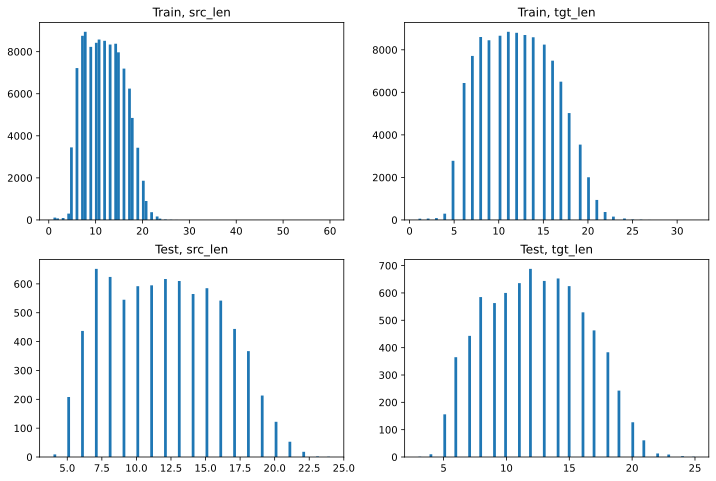

In [112]:
from utils.tokenizer import tokenizer

train = pd.read_csv(DATA_DIR/'train.csv', header=None)
train.columns = ['id', 'src', 'tgt']
train_src_len = train['src'].apply(lambda x: len(tokenizer(x)))
train_tgt_len = train['tgt'].apply(lambda x: len(tokenizer(x)))

test = pd.read_csv(DATA_DIR/'test.csv', header=None)
test.columns = ['id', 'src', 'tgt']
test_src_len = test['src'].apply(lambda x: len(tokenizer(x)))
test_tgt_len = test['tgt'].apply(lambda x: len(tokenizer(x)))

figure, ax = plt.subplots(2, 2, figsize=(12, 8))
# train
ax[0, 0].hist(train_src_len, bins=100)
ax[0, 0].set_title('Train, src_len')
ax[0, 1].hist(train_tgt_len, bins=100)
ax[0, 1].set_title('Train, tgt_len')

# test
ax[1, 0].hist(test_src_len, bins=100)
ax[1, 0].set_title('Test, src_len')
ax[1, 1].hist(test_tgt_len, bins=100)
ax[1, 1].set_title('Test, tgt_len')

plt.show()



## PyTorch datasets

In [120]:
%autoreload 2
from utils.data import get_datasets_and_vocab

train_dataset, validation_dataset, test_dataset, vocab = get_datasets_and_vocab(
    path_to_files=DATA_DIR,
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    train_size=1000,
#     validation_size=1000,
#     use_glove_vectors=True,
#     vectors_cache=VECTORS_CACHE_DIR,
)

from utils.util import save_vocab
save_vocab(vocab, ARTIFACTS_DIR/f'vocab_{len(vocab)}')
print(f'Vocab size: {len(vocab):,}')

Vocab size: 846


## Vocabulary

In [121]:
vocab.freqs

Counter({'hi': 73,
         ',': 574,
         'how': 179,
         'are': 270,
         'you': 723,
         'doing': 59,
         '?': 635,
         'i': 1623,
         "'": 479,
         'm': 216,
         'getting': 7,
         'ready': 5,
         'to': 510,
         'do': 413,
         'some': 37,
         'cheetah': 1,
         'chasing': 2,
         'stay': 9,
         'in': 208,
         'shape': 1,
         '.': 1597,
         'am': 204,
         '!': 339,
         'for': 166,
         'my': 414,
         'hobby': 11,
         'like': 240,
         'canning': 3,
         'or': 32,
         'whittling': 1,
         'that': 290,
         's': 98,
         'neat': 6,
         'when': 42,
         'was': 75,
         'high': 11,
         'school': 39,
         'placed': 1,
         '6th': 1,
         '100m': 1,
         'dash': 1,
         'not': 167,
         'but': 130,
         'have': 246,
         'a': 523,
         'favorite': 64,
         'meat': 10,
         'since': 16,


## PyTorch DataLoaders

In [122]:
%autoreload 2
from utils.data import get_dataloaders

train_iter, validation_iter, test_iter = get_dataloaders(
    train_dataset, validation_dataset, test_dataset,
    batch_size=2400,
    device=DEVICE
)

x = next(iter(train_iter))
print('Example \n-------')
print(x.src[0])
print(x.src[1])

Example 
-------
tensor([[  2,   6,  18,  ...,   1,   1,   1],
        [  2,  80,   8,  ...,   1,   1,   1],
        [  2,  47, 394,  ...,   1,   1,   1],
        ...,
        [  2,  71,  67,  ...,   1,   1,   1],
        [  2,  52,   4,  ...,   1,   1,   1],
        [  2,  12, 323,  ...,   1,   1,   1]])
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 19, 19,
        19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 25,
        24, 24, 24, 23, 22, 23, 22, 22, 22, 22, 24, 22, 22, 22, 22, 23, 22, 21,
        21, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 21])


## Model

In [124]:
%autoreload 2
from model import Seq2seqRNN
from utils.util import count_parameters

hidden_dim = 256
n_layers = 3
n_directions_encoder = 2
model = Seq2seqRNN(vocab_size=len(vocab),
                   embedding_dim=vocab.vectors.shape[1],
                   hidden_dim=256,
                   n_layers=3,
                   n_directions_encoder=2,
                   device=DEVICE,
                   dropout=0.2,
#                    pretrained_embeddings=vocab.vectors,
#                    freeze_embeddings=False,
#                    attention_type='dot'
                  )

print(f'The model has {count_parameters(model):,} parameters')

The model has 5,608,390 parameters


## Train

In [125]:
%autoreload 2
from train import Seq2seqRNNTrainer
from utils.data import PAD_TOKEN

trainer = Seq2seqRNNTrainer(model,
                            train_iter,
                            validation_iter,
                            learning_rate=3e-4,
                            pad_token_id=vocab.stoi[PAD_TOKEN],
                            gradient_clip=1,
                            teacher_forcing=0.5,
                            checkpoint_dir=ARTIFACTS_DIR)
n_epochs = 10
trainer.train_test_loop(n_epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 000, Train loss: 6.7161, Val loss: 6.6335, Train ppl: 825.6, Val ppl: 760.1
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/0.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 001, Train loss: 6.4021, Val loss: 5.6588, Train ppl: 603.1, Val ppl: 286.8
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/1.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 002, Train loss: 5.3199, Val loss: 4.8217, Train ppl: 204.4, Val ppl: 124.2
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/2.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 003, Train loss: 4.8745, Val loss: 4.6777, Train ppl: 130.9, Val ppl: 107.5
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/3.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 004, Train loss: 4.7888, Val loss: 4.6494, Train ppl: 120.2, Val ppl: 104.5
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/4.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 005, Train loss: 4.7568, Val loss: 4.6268, Train ppl: 116.4, Val ppl: 102.2
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/5.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 006, Train loss: 4.7434, Val loss: 4.6304, Train ppl: 114.8, Val ppl: 102.6


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 007, Train loss: 4.7282, Val loss: 4.6110, Train ppl: 113.1, Val ppl: 100.6
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/7.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 008, Train loss: 4.7175, Val loss: 4.6138, Train ppl: 111.9, Val ppl: 100.9


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 009, Train loss: 4.7018, Val loss: 4.6001, Train ppl: 110.1, Val ppl: 99.5
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/9.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


## In case you want to resume training from a saved checkpoint

In [ ]:
run_id = '116f63f4-6ab8-11eb-a582-acbc32b70c09'
trainer.load(run_id=run_id, epoch=9)

n_epochs = 10
trainer.train_test_loop(n_epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 000, Train loss: 4.6936, Val loss: 4.5945, Train ppl: 109.3, Val ppl: 98.9
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/9.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 001, Train loss: 4.6872, Val loss: 4.5905, Train ppl: 108.6, Val ppl: 98.5
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/10.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]